# BDMI inocmpatibilities / gene interactions?

Install `bitarrays`:

In [1]:
# conda install -c conda-forge bitarray

Imports:

In [3]:
import numpy as np
import pandas as pd
from math import log
from scipy.stats import binom
from bitarray import bitarray
from bitarray.util import count_xor, zeros
from numpy.random import randint
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("ticks")
# scale plots
sns.set_context("paper")
# import matplotlib as mpl
# scale = 0.8
# d = dict([(k, v*scale) for (k, v) in sns.plotting_context('paper').items()])
# d['figure.figsize'] = [5.4, 3.5]
# mpl.rcParams.update(d)

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

## Test data

Function for making chrX dataframes like the ones you have. Admixture is 50% and random except for two pairs of windows with mixes ancestry that match up perfectly and one pair of windows with uniform ancestry that match up perfectly. For simplicity I assume only males for now.

In [4]:
admix_prop = 0.2
np.random.choice([0, 1], size=10, p=[1-admix_prop, admix_prop])

array([0, 1, 0, 0, 0, 1, 0, 0, 1, 0])

In [5]:
def dummy_data(window_size, admix_prob, nr_indivs, par1_size):

    begin = (par1_size // window_size + 1) * window_size
    a = np.array(range(begin, 153000000, window_size))
    nr_windows = len(a)
    lst = []
    for indiv in range(0, nr_indivs):
        df = pd.DataFrame(dict(start=a, 
                               end=a+window_size, 
                               is_north=np.random.choice([0, 1], size=nr_windows, p=[1-admix_prop, admix_prop])
                              )
                         )
        df['male'] = indiv
        lst.append(df)
    df = pd.concat(lst)
    df = df[['male', 'start', 'end', 'is_north']]
    
    # add a single window 30000000 with perfect match to window 50000000
    males = np.random.randint(0, nr_indivs, size=nr_indivs//2)
    df.loc[(df.start == 30000000), 'is_north'] = 0
    df.loc[df.male.isin(males) & (df.start == 30000000), 'is_north'] = 1
    df.loc[(df.start == 50000000), 'is_north'] = 0
    df.loc[df.male.isin(males) & (df.start == 50000000), 'is_north'] = 1

    # add a single window 40000000 with perfect match to window 60000000
    males = np.random.randint(0, nr_indivs, size=nr_indivs//2)
    df.loc[(df.start == 40000000), 'is_north'] = 0
    df.loc[df.male.isin(males) & (df.start == 40000000), 'is_north'] = 1
    df.loc[(df.start == 60000000), 'is_north'] = 0
    df.loc[df.male.isin(males) & (df.start == 60000000), 'is_north'] = 1
    
    # add a single homogeneous window 80000000 with perfect match to window 100000000
    df.loc[(df.start == 80000000), 'is_north'] = 1
    df.loc[(df.start == 100000000), 'is_north'] = 1

    df['admix_prop'] = 0
    df.loc[df.is_north == 1, 'admix_prop'] = 1 - np.abs(np.random.random(len(df.loc[df.is_north == 1]))) / 4
    df.loc[df.is_north == 0, 'admix_prop'] = np.abs(np.random.random(len(df.loc[df.is_north == 0]))) / 4
    
    # # round admix proportion to 0 / 1: is north or not
    # df['is_north'] = df.admix_prop.round().astype(int)
    
    return df

df = dummy_data(100000, 0.3, 100, 2600000)  
df.head()

,male,start,end,is_north,admix_prop
0,0,2700000,2800000,0,0.116446
1,0,2800000,2900000,0,0.016222
2,0,2900000,3000000,0,0.205050
3,0,3000000,3100000,0,0.082197
4,0,3100000,3200000,1,0.965611


In [6]:
chrX_100kb_windows = pd.read_csv('~/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/all_chrX.windows.txt', sep='\t')
chrX_100kb_windows.head()

,chrom,individual,haplotype,start,end,north_sum
0,all_chrX,PD_0228,0,0,100000,0
1,all_chrX,PD_0228,0,100000,200000,0
2,all_chrX,PD_0228,0,200000,300000,0
3,all_chrX,PD_0228,0,300000,400000,0
4,all_chrX,PD_0228,0,400000,500000,0


In [7]:
l = [f'PD_07{i}' for i in range(20, 45)]
l

['PD_0720',
 'PD_0721',
 'PD_0722',
 'PD_0723',
 'PD_0724',
 'PD_0725',
 'PD_0726',
 'PD_0727',
 'PD_0728',
 'PD_0729',
 'PD_0730',
 'PD_0731',
 'PD_0732',
 'PD_0733',
 'PD_0734',
 'PD_0735',
 'PD_0736',
 'PD_0737',
 'PD_0738',
 'PD_0739',
 'PD_0740',
 'PD_0741',
 'PD_0742',
 'PD_0743',
 'PD_0744']

In [8]:
#chrX_100kb_windows.individual.tolist()#.isin(chrX_100kb_windows)

In [9]:
females = ['Sci_16066', 'Sci_16098', 'Sci_34449', 'Sci_34474', 'Sci_97074', 'PD_0199', 'PD_0200', 'PD_0203',
           'PD_0205', 'PD_0206', 'PD_0208', 'PD_0209', 'PD_0210', 'PD_0211', 'PD_0212', 'PD_0213', 'PD_0214',
           'PD_0216', 'PD_0219', 'PD_0221', 'PD_0222', 'PD_0224', 'PD_0225', 'PD_0226', 'PD_0232', 'PD_0237', 
           'PD_0238', 'PD_0239', 'PD_0240', 'PD_0241', 'PD_0243', 'PD_0244', 'PD_0265', 'PD_0270', 'PD_0271', 
           'PD_0272', 'PD_0390', 'PD_0391', 'PD_0392', 'PD_0393', 'PD_0394', 'PD_0492', 'PD_0495', 'PD_0499', 
           'PD_0500', 'PD_0501', 'PD_0503', 'PD_0506', 'PD_0507', 'PD_0509', 'PD_0641', 'PD_0649', 'PD_0651', 
           'PD_0652', 'PD_0653', 'PD_0659', 'PD_0662', 'PD_0674', 'PD_0675', 'PD_0676', 'PD_0677', 'PD_0678',
           'PD_0680', 'PD_0682', 'PD_0683', 'PD_0685', 'PD_0686', 'PD_0693', 'PD_0694', 'PD_0695', 'PD_0698', 
           'PD_0700', 'PD_0701', 'PD_0708', 'PD_0710', 'PD_0721', 'PD_0724', 'PD_0726', 'PD_0730', 'PD_0736', 
           'PD_0737', 'PD_0738', 'PD_0744', 'PD_0745', 'PD_0754', 'PD_0760', 'PD_0765', 'PD_0769', 'PD_0770', 
           'PD_0772', 'PD_0773', 'PD_0774', 'PD_0781', 'PD_0788', 'PD_0789', 'PD_0790', 'PD_0791', 'PD_0792']

In [32]:
df = chrX_100kb_windows.loc[chrX_100kb_windows.individual.isin(l)]
df_females1 = df.loc[df.individual.isin(females)].copy()
df_females2 = df.loc[df.individual.isin(females)].copy()
df_males = df.loc[~df.individual.isin(females)].copy()

df_males['is_north'] = np.abs(((df_males['north_sum'])/100000).round()).astype(int)
df_females1['is_north'] = np.abs(((df_females1['north_sum'])/100000).round()).astype(int)
df_females2['is_north'] = np.abs(((df_females2['north_sum'])/100000).round()).astype(int)

df_females2.loc[(25000 < df_females2.north_sum) & (df_females2.north_sum < 75000), 'is_north'] = np.abs(((df_females2['north_sum']-50000)/100000).round()).astype(int)

#df_females2['is_north'] = np.abs(((df_females2['north_sum']+49999)/100000).round()).astype(int)




df = pd.concat([df_males, df_females1, df_females2])#.sort_values(['individual', 'start', ' end'])

chrX_100kb_windows['indiv'] = [f'{a}_{b}' for a, b in zip(chrX_100kb_windows.individual, chrX_100kb_windows.haplotype)]

chrX_100kb_windows.sort_values(['indiv', 'start'], inplace=True)

#df = pd.concat([df_females1])
df.head()

,chrom,individual,haplotype,start,end,north_sum,indiv,is_north
40236,all_chrX,PD_0720,0,0,100000,0,PD_0720_0,0
40237,all_chrX,PD_0720,0,100000,200000,0,PD_0720_0,0
40238,all_chrX,PD_0720,0,200000,300000,0,PD_0720_0,0
40239,all_chrX,PD_0720,0,300000,400000,0,PD_0720_0,0
40240,all_chrX,PD_0720,0,400000,500000,0,PD_0720_0,0


In [33]:
df.haplotype.unique()

array([0, 1])

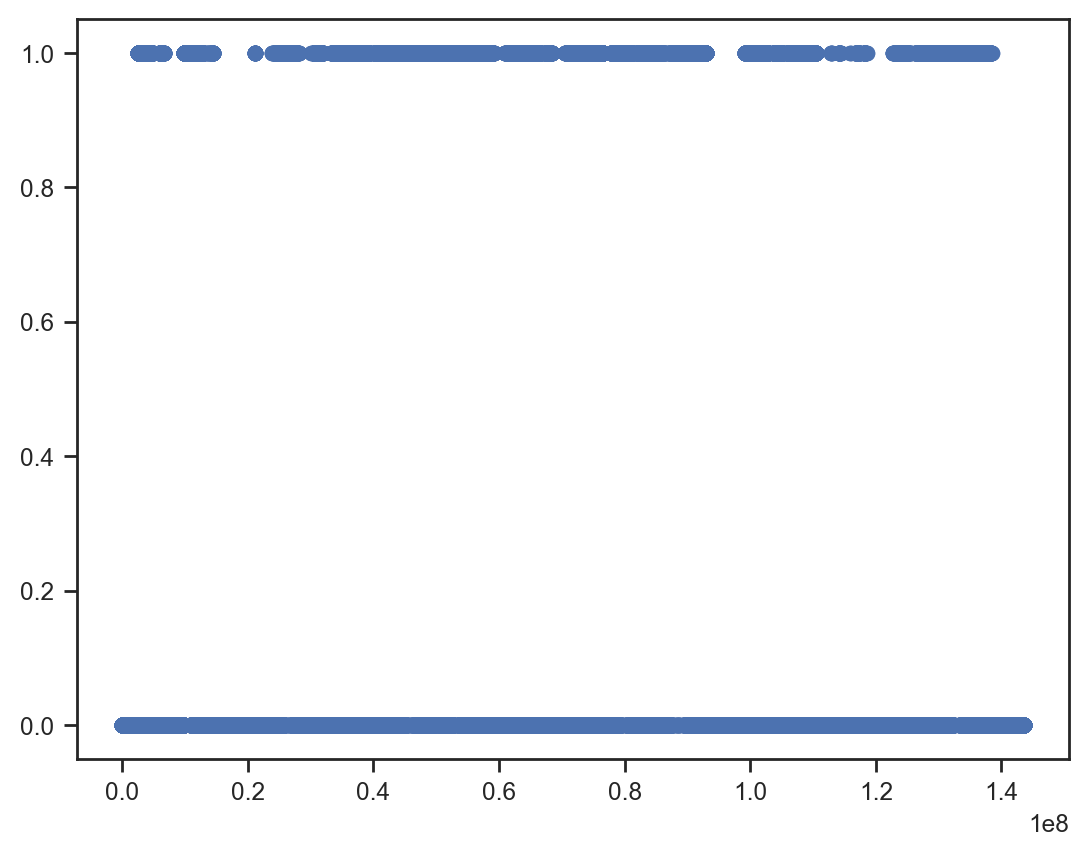

In [34]:
plt.scatter(df.start, df.is_north)

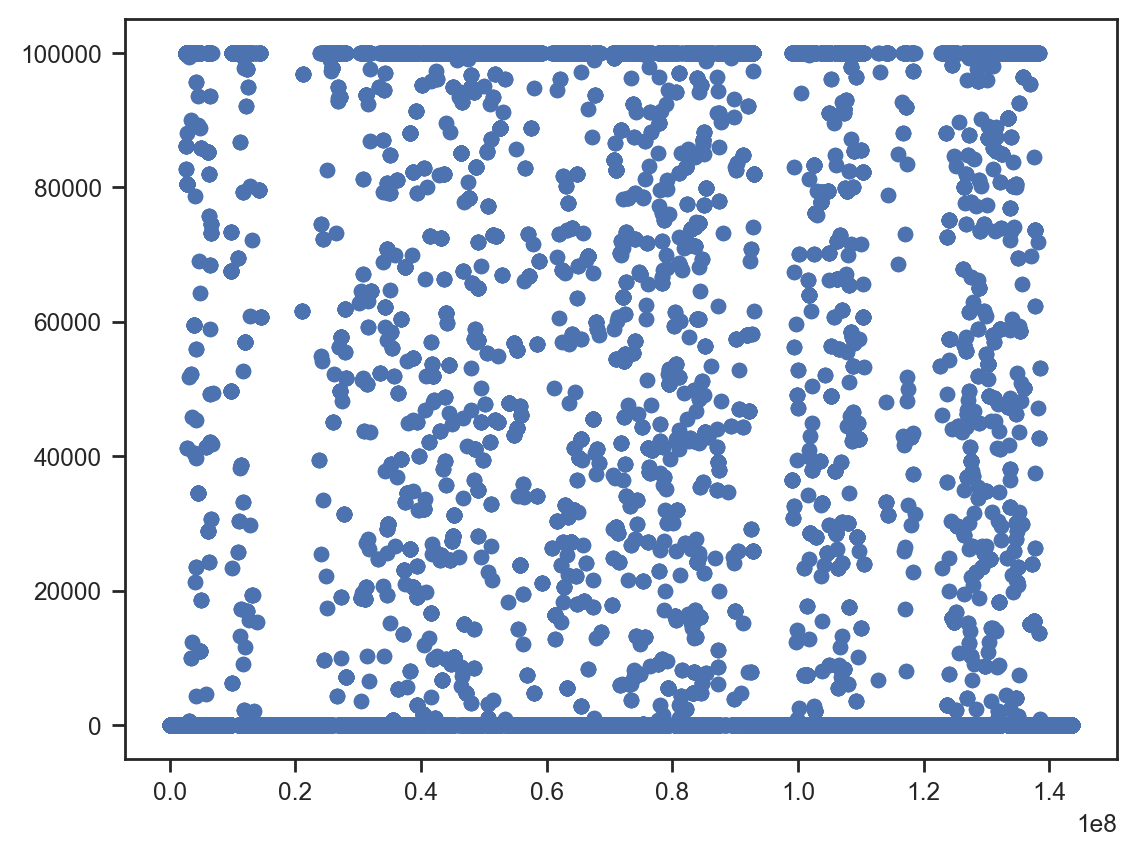

In [35]:
plt.scatter(df.start, df.north_sum)

In [36]:
df.is_north.mean()

0.3257839353872757

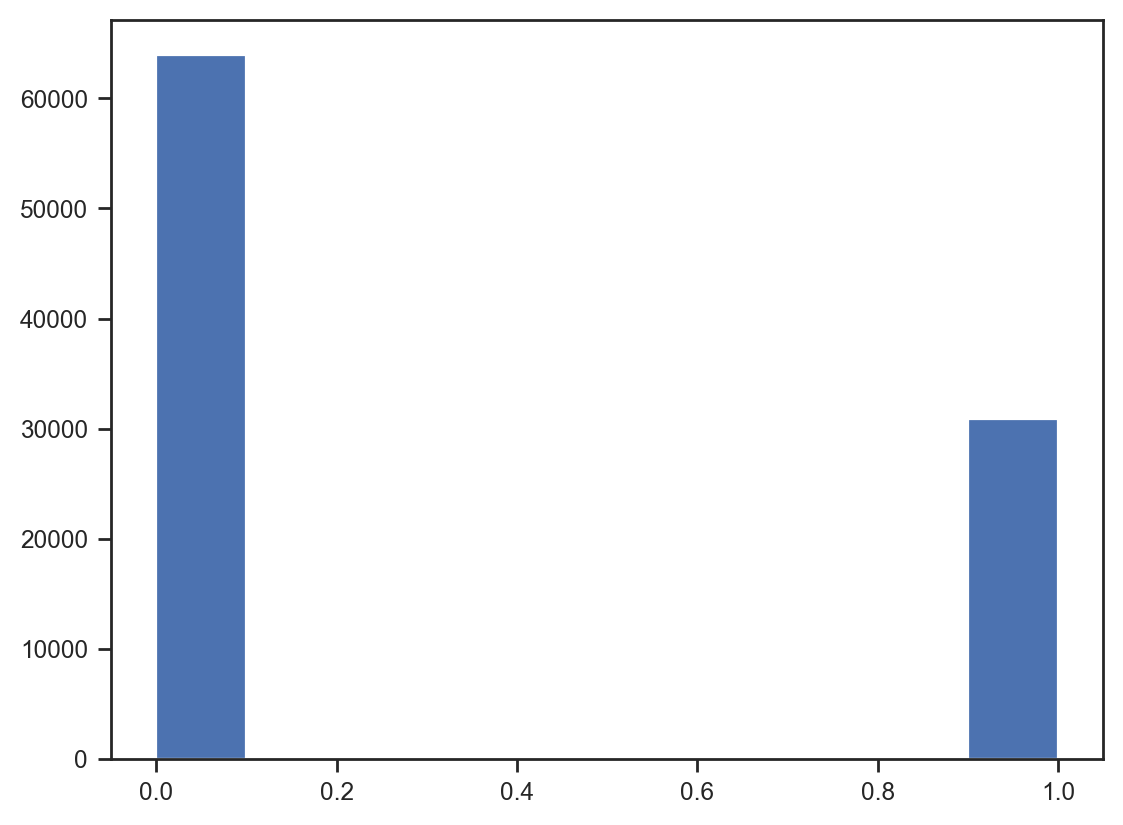

In [37]:
plt.hist(df.is_north) ;

In [38]:
# def dummy_data(window_size, admix_prob, nr_indivs, par1_size):

#     begin = (par1_size // window_size + 1) * window_size
#     a = np.array(range(begin, 153000000, window_size))
#     nr_windows = len(a)
#     lst = []
#     for indiv in range(0, nr_indivs):
#         df = pd.DataFrame(dict(start=a, end=a+window_size, admix_prop=1-np.random.random(size=nr_windows)))
#         df['male'] = indiv
#         lst.append(df)
#     df = pd.concat(lst)
#     df = df[['male', 'start', 'end', 'admix_prop']]
    
#     # add a single window 30000000 with perfect match to window 50000000
#     males = np.random.randint(0, nr_indivs, size=nr_indivs//2)
#     df.loc[(df.start == 30000000), 'admix_prop'] = 0
#     df.loc[df.male.isin(males) & (df.start == 30000000), 'admix_prop'] = 1
#     df.loc[(df.start == 50000000), 'admix_prop'] = 0
#     df.loc[df.male.isin(males) & (df.start == 50000000), 'admix_prop'] = 1

#     # add a single window 40000000 with perfect match to window 60000000
#     males = np.random.randint(0, nr_indivs, size=nr_indivs//2)
#     df.loc[(df.start == 40000000), 'admix_prop'] = 0
#     df.loc[df.male.isin(males) & (df.start == 40000000), 'admix_prop'] = 1
#     df.loc[(df.start == 60000000), 'admix_prop'] = 0
#     df.loc[df.male.isin(males) & (df.start == 60000000), 'admix_prop'] = 1
    
#     # add a single homogeneous window 80000000 with perfect match to window 100000000
#     df.loc[(df.start == 80000000), 'admix_prop'] = 1
#     df.loc[(df.start == 100000000), 'admix_prop'] = 1

#     # round admix proportion to 0 / 1: is north or not
#     df['is_north'] = df.admix_prop.round().astype(int)
    
#     return df

# df = dummy_data(100000, 100, 2600000)  
# df.head()

## Pairing statistics

Functions for computing two statistics for pairs of windows using bitarrays:

- Proportion of piared ancestry: the proportion of individuals that have the same ancestry in the two windows.
- Mutual information: mutual information across between the two windows (assumes 50% admixture for now).

`compute_matrix` returns candidate pairs for windows and the matrix of all stats for plotting. "significant" pairs are:

- Proportion of piared ancestry: bernoulli corrected binomial significance.
- Mutual information: 0.9 * perfect mutual information for the sample size (assumes 50% admixture for now).

In [39]:
def get_pairs(m, cutoff):
    m = m.copy()
    np.fill_diagonal(m, 0)
    dependent_windows = np.argwhere((m > cutoff))
    dependent_windows.sort()
    dependent_windows = np.unique(dependent_windows[dependent_windows[:, 0].argsort()], axis=0)
    return dependent_windows.tolist()


def bitarray_mut_info(b1, b2):
    epsilon = 1e-12
    x11 = (b1 & b2).count(1) + epsilon 
    x10 = (b1 ^ b2 & b1).count(1) + epsilon 
    x01 = (b2 ^ b1 & b2).count(1) + epsilon 
    x00 = (b1 | b2).count(0) + epsilon 
    tot = x11 + x10 + x01 + x00
    x11 /= tot
    x10 /= tot
    x01 /= tot
    x00 /= tot
    x_1 = x11 + x01
    x1_ = x11 + x10
    x_0 = x00 + x10
    x0_ = x00 + x01
    mut_info = x11*log(x11/(x1_*x_1)) + x10*log(x10/(x1_*x_0)) + x01*log(x01/(x0_*x_1)) + x00*log(x00/(x0_*x_0))
    return mut_info


def compute_matrix(df, stat='proportion_paired'):

    grouped = df.groupby('start')
    nr_indivs = grouped.agg('size').max()
    window_size = (df.end - df.start).max()
    nr_windows = grouped.ngroups

    columns = {}
    for start, group in grouped:
        columns[start] = bitarray(group.is_north.tolist())
        
    index_array = np.array(np.meshgrid(range(nr_windows), range(nr_windows))) * window_size

    def proportion_paired(args):
        i, j = args
        if i in columns and j in columns:
            return (nr_indivs - count_xor(columns[i], columns[j])) / nr_indivs
        else:
            return np.nan

    # def fun(args):
    #     i, j = args
    #     if i in columns and j in columns:
    #         return mutual_info_score(columns[i].tolist(), columns[j].tolist())
    #     else:
    #         return np.nan
    
    def mutual_information(args):
        i, j = args
        if i in columns and j in columns:
            return bitarray_mut_info(columns[i], columns[j])
        else:
            return np.nan    
        
    mean_admix_prop = df.is_north.mean()
    match_prob = mean_admix_prop**2 + (1-mean_admix_prop)**2
        
    if stat == 'prop_paired':
        m = np.apply_along_axis(proportion_paired, 0, index_array)
        p_value = 1 / df.start.nunique()**2
        min_signif = binom.ppf(1-p_value, nr_indiv, match_prob) / nr_indiv
        interacting_windows = get_pairs(m, min_signif)        
        return interacting_windows, m        
    elif stat == 'mut_info':
        m = np.apply_along_axis(mutual_information, 0, index_array)
        
        lst = []
        for _ in range(100):
            b = bitarray(np.random.choice([0, 1], size=nr_windows, p=[1-mean_admix_prop, mean_admix_prop]).tolist())
            # b = bitarray(np.random.randint(0, 2, size=nr_indivs).tolist())
            lst.append(bitarray_mut_info(b, ~b))
        perfect = sum(lst)/len(lst) # mut info for perfectly matching cols (assuming 0.5 admixture prop)
        interacting_windows = get_pairs(m, perfect*0.95) 
        return interacting_windows, m            
    else:
        assert 0

## Testing it

Make a test data frame:

In [40]:
# window_size = 1000000 # 1mb
window_size = 100000 # 100kb
# window_size = 10000 # 10kb
par1_size = 2600000
nr_indiv = 25
admix_prop = 0.2

In [41]:
#df = dummy_data(window_size, admix_prop, nr_indiv, par1_size)

Compute proportion paired:

In [42]:
%%time
pp_interacting_windows, pp_m = compute_matrix(df, stat='prop_paired')

CPU times: user 6.08 s, sys: 11 ms, total: 6.09 s
Wall time: 6.15 s


Compute mutual information:

In [43]:
%%time
mi_interacting_windows, mi_m = compute_matrix(df, stat='mut_info')

CPU times: user 9.51 s, sys: 12.8 ms, total: 9.52 s
Wall time: 9.66 s


Plot matrices with lines connecting interacting pairs found by each method:

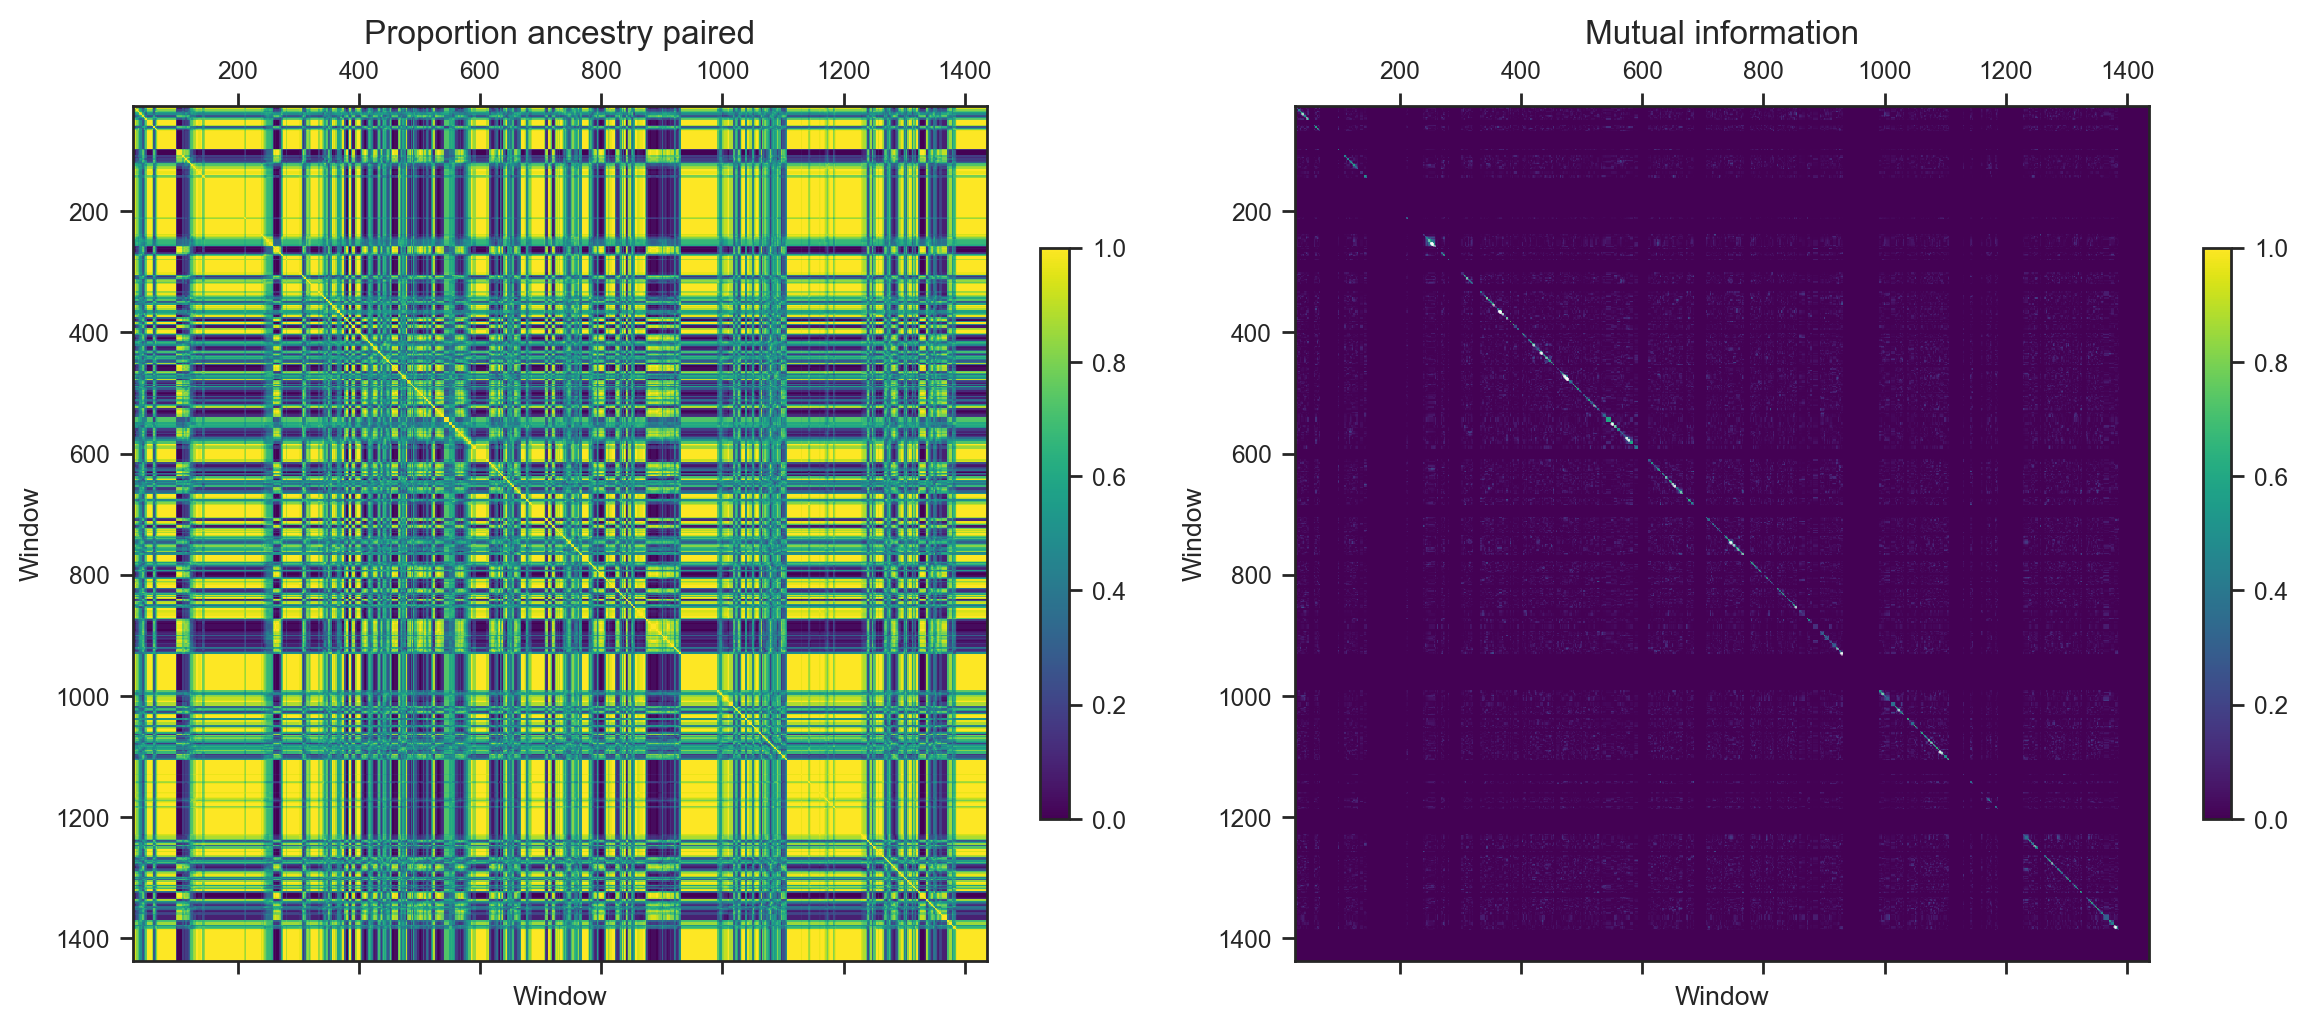

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
g = ax1.matshow(pp_m, cmap='viridis', vmin=0, vmax=1)
ax1.set_xlim(left=(par1_size//window_size)+1)
ax1.set_ylim(top=(par1_size//window_size)+1)
ax1.set_xlabel('Window')
ax1.set_ylabel('Window')
ax1.set_title('Proportion ancestry paired', fontsize=12)
cb = fig.colorbar(g, location='right', ax=ax1, shrink=0.5)
for a, b in pp_interacting_windows:
    ax1.vlines(a, a, b, color='white', linewidth=1, alpha=0.7)
    ax1.hlines(b, b, a, color='white', linewidth=1, alpha=0.7)
g = ax2.matshow(mi_m, cmap='viridis', vmin=0, vmax=1)
ax2.set_xlim(left=(par1_size//window_size)+1)
ax2.set_ylim(top=(par1_size//window_size)+1)
ax2.set_xlabel('Window')
ax2.set_ylabel('Window')
ax2.set_title('Mutual information', fontsize=12)
cb = fig.colorbar(g, location='right', ax=ax2, shrink=0.5)
for a, b in mi_interacting_windows:
    ax2.vlines(a, a, b, color='white', linewidth=1, alpha=0.7)
    ax2.hlines(b, b, a, color='white', linewidth=1, alpha=0.7)
plt.tight_layout()

## Horizon plot with females as diploids

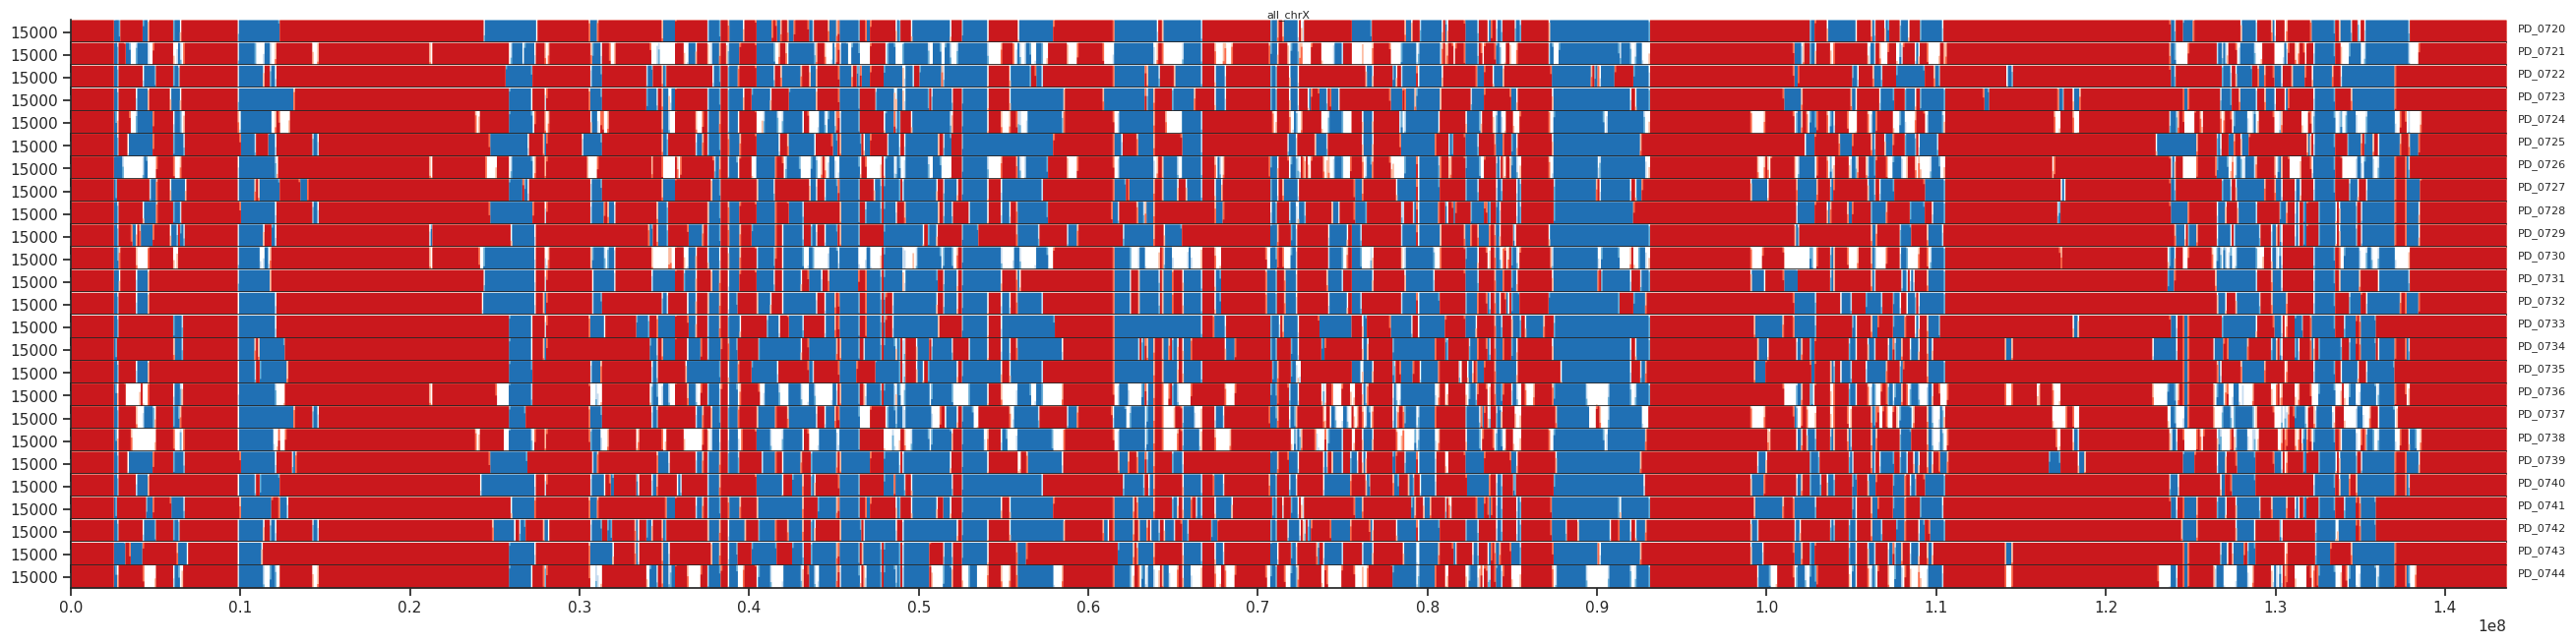

## Plot the interacting positions along the chromosome

Showing only those more than 1Mb appart. Red vertical lines are the few low-pi windows from Erik.

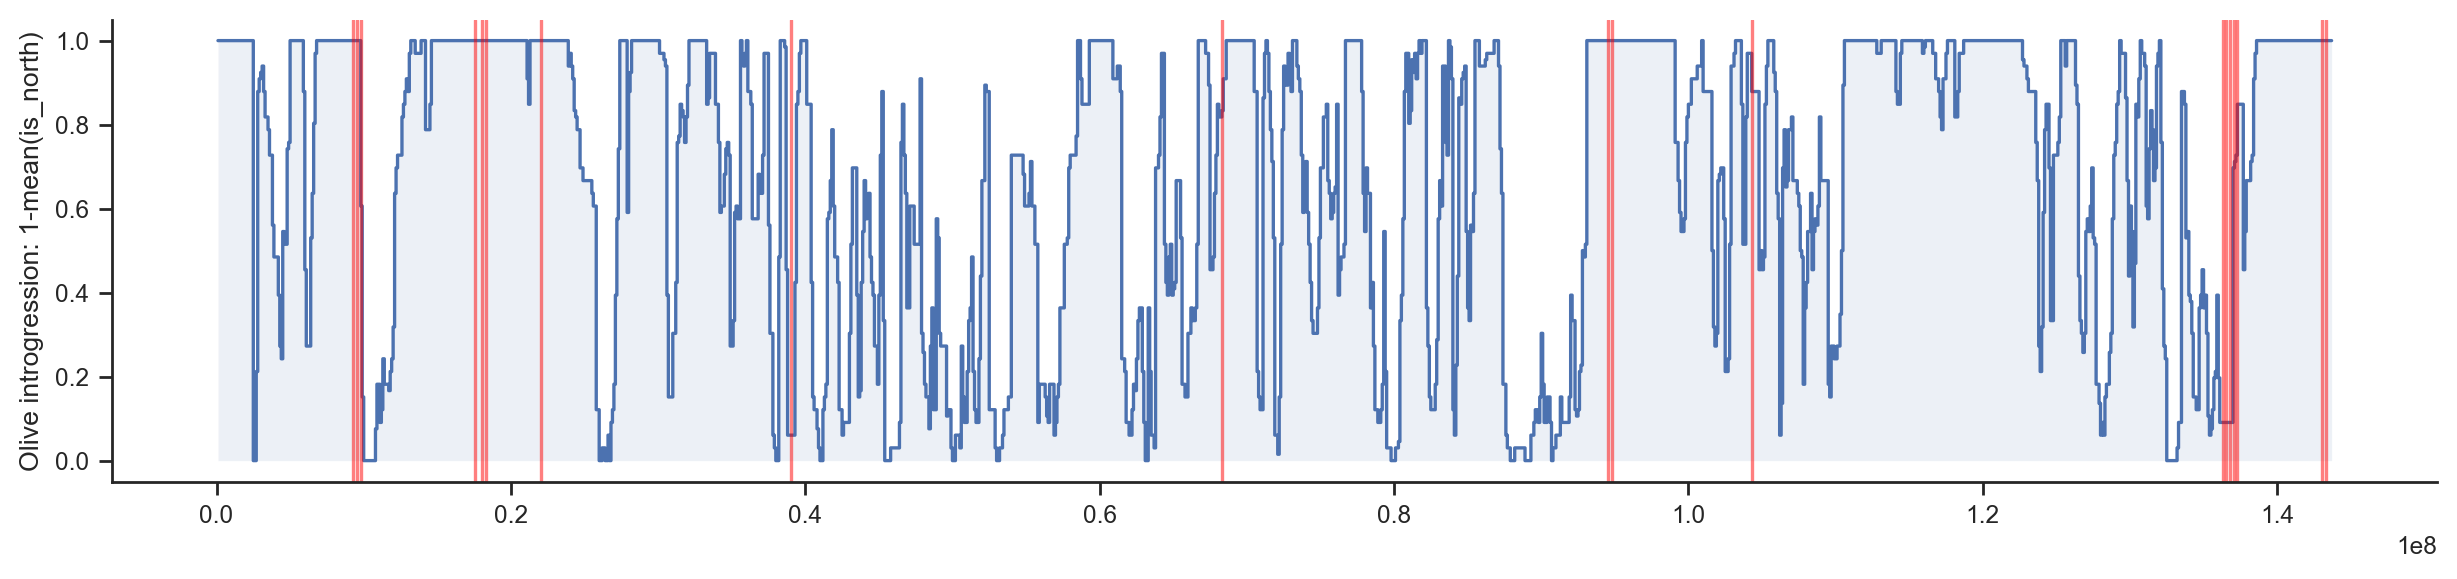

In [98]:
# xmin, xmax = 23_000_000, 27_000_000
xmin, xmax = 0, 160_000_000
min_distance = 1_000_000

plt.figure(figsize=(15, 3))
plot_df = df.loc[(df.start > xmin) & (df.start < xmax)].groupby('start').is_north.mean().to_frame('is_north').reset_index()
plot_df['end'] = plot_df.start + window_size
plot_df = stairs(plot_df)
plt.plot(plot_df.pos, 1-plot_df.is_north)
plt.fill_between(plot_df.pos, 1-plot_df.is_north, 0, alpha=0.1)
plt.ylabel('Olive introgression: 1-mean(is_north)')
y = -1

for i, (a, b) in enumerate(pp_interacting_windows):
    if b - a > min_distance and (xmin < a*100000 < xmax or xmin < b*100000 < xmax):
        plt.axvline(a*window_size+window_size/2, color=f'C{i+1}', zorder=-1)
        plt.axvline(b*window_size+window_size/2, color=f'C{i+1}', zorder=-1)
        plt.plot([a*window_size+window_size/2, b*window_size+window_size/2], [y, y], '-o', color=f'C{i+1}')
        y -= 1
y -= 5
for i, (a, b) in enumerate(mi_interacting_windows):
    if b - a > min_distance and (xmin < a*100000 < xmax or xmin < b*100000 < xmax):
        plt.axvline(a*window_size+window_size/2, color=f'C{i+1}', zorder=-1)
        plt.axvline(b*window_size+window_size/2, color=f'C{i+1}', zorder=-1)
        plt.plot([a*window_size+window_size/2, b*window_size+window_size/2], [y, y], '-o', color=f'C{i+1}')
    y -= 1
    
    
low_pi_windows_from_erik = [9250000, 9500000, 9750000, 17500000, 18000000, 18250000, 22000000,
                            39000000, 68250000, 94500000, 94750000, 104250000, 136250000, 136500000, 
                            136750000, 137000000, 137250000, 143000000, 143250000]   
[plt.axvline(x+50_000, color='red', alpha=0.5) for x in low_pi_windows_from_erik]
    
sns.despine()

- 37       9250000 *FRMPD4* (accel Simiiformes), 
    - Through its interaction with other proteins (such as PSD-95), it functions as a positive regulator of dendritic spine morphogenesis and density, and is required for the maintenance of excitatory synaptic transmission.
- 38       9500000 *FRMPD4* (accel Simiiformes)
- 39       9750000 *FRMPD4* (accel Simiiformes) - border
- 70      17500000 EIF1AX (human sweep, cDEG)
- 72      18000000 UQCRQ
- 73      18250000 UQCRQ - border
- 88      22000000 POLA1 (intel. disability, accel Simiiformes), **ARX**
- 156     39000000 *CASK* (accel Simiiformes)
- 273     68250000 *ATRX* (human sweep)
- 378     94500000 **IL1RAPL2** - border
- 379     94750000 **IL1RAPL2**
- 417    104250000 **IL13RA2** (human sweep) - border
- 545    136250000 *FMR1*, AFF2 (cDEG)
- 546    136500000 *FMR1*, AFF2  (cDEG)
- 547    136750000 *AFF2* (cDEG)
- 548    137000000 *AFF2* (cDEG)
- 549    137250000 *AFF2* (cDEG)
- 572    143000000 CLIC2, **TMLHE**
- 573    143250000 **TMLHE**

----
Key:
- *Italic* Genes related to autism associated neuroanatomy
- **Bold**: Bold genes are SFARI autism genes.
- (accel Simiiformes): Non-coding regions with accelerated evolution in the long branch leading to simiformes.
- (human sweep): The sweeps I find in non-Africans
- (cDEG): Differential expression in cytoplasm of X and Y spermatid (driver potential)
- border: the window is at the border between chromatin compartments